# Wstęp
Zadanie 12 jest trzecią częścią do zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2. Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3. Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem trzeciego etapu prac jest ewaluacja modelu MultiBTC sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji.

# Warunki zaliczenia

Do zaliczenia trzeciego etapu należy wytrenować modelu oraz wykonać ewaluację predykcji dla scenariusza godzinnego oraz dziennego, z uwzględnieniem wpływu:
 * wybranych hiperparametrów
 * dodatkowych kroków wstępnego przetwarzania danych
 * wymiarów afektywnych


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/dnn/
!pwd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dnn
/content/drive/MyDrive/dnn


# Realizacja zadania

Szczegółowa realizacja zadania powinna uwzględniać następujące elementy ewaluacji:

### Hiperparametry (4 pkt.)

W zadaniu tym istnieje szereg ustawień hiperparametrów, które mogą mieć istotny wpływ na jakość predykcji. Należy wybrać jeden z nich i zbadać jego wpływ dla 3 wybranych wartości.

1. Długość sekwencji w modelu LSTM.
2. Liczba jednostek w warstwie ukrytej.
3. Optymalizator i jego parametry (np. `learning rate`).
4. Użycie dodatkowej warstwy Dropout (parametr: `probability`) przed warstwą z wynikiem predykcji.

### Przetwarzanie wstępne (3 pkt.)

Jednocześnie istotny wpływ mogą mieć dodatkowe elementy przetwarzania wstępnego danych. Należy wybrać jeden z nich i porównać z wariantem bez przetwarzania:
1. Normalizacja wartości (sprowadzenie konkretnych kwot do wartości z zakresu 0-1).
2. Zamiana wartości liczbowej na procentową zmianę względem poprzedniego kursu.

### Wymiary afektywne  (3 pkt.)

Ostatnim aspektem jest zbadanie wpływu wymiarów afektywnych. Dla najlepszej otrzymanej konfiguracji należy porównać wyniki z modelem, który wykorzystuje wyłącznie dane z giełdy.

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:
1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


In [23]:
import pandas as pd

concat_1h = pd.read_csv('concat_1h.csv')
concat_24h = pd.read_csv('concat_24h.csv')

In [24]:
def split_to_train_test(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    data = data.sort_values('date').reset_index(drop=True)
    train_data = data.iloc[:int(len(data) * train_ratio)]
    val_data = data.iloc[int(len(data) * train_ratio):int(len(data) * (train_ratio + val_ratio))]
    test_data = data.iloc[int(len(data) * (train_ratio + val_ratio)):]
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_data_1h, val_data_1h, test_data_1h = split_to_train_test(concat_1h)
train_data_24h, val_data_24h, test_data_24h = split_to_train_test(concat_24h)

train_data_1h

,date,open,high,low,close,volume,involvement,irony,offensive
0,2018-01-01 00:00:00,13880.00,13906.37,13600.26,13668.52,275.555024,252,4,6
1,2018-01-01 01:00:00,13635.06,13704.42,13312.94,13355.00,393.344524,1080,1,5
2,2018-01-01 02:00:00,13355.00,13536.88,13302.02,13429.08,194.327902,213,3,1
3,2018-01-01 03:00:00,13407.98,13640.00,13321.90,13481.73,317.537375,114,3,6
4,2018-01-01 04:00:00,13481.73,13699.14,13372.41,13697.00,457.691397,386,4,3
...,...,...,...,...,...,...,...,...,...
15222,2019-12-17 23:00:00,6586.63,6630.00,6550.00,6612.30,257.838675,525,0,0
15223,2019-12-18 00:00:00,6619.53,6650.00,6590.62,6642.12,100.935222,181,1,2
15224,2019-12-18 01:00:00,6641.22,6677.08,6634.46,6650.12,405.747175,183,0,4
15225,2019-12-18 02:00:00,6650.12,6706.70,6637.97,6692.97,133.689678,362,0,0


In [25]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5, dropout_after_lstm=False):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_after_lstm = dropout_after_lstm

        self.lstms = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)

        lstm_out, _ = self.lstms(x, (h_0, c_0))
        if self.dropout_after_lstm:
            lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [26]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: nn.MSELoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    epochs: int,
    print_metrics: bool = False,
    name: str ='',
    patience: int = 3
):
    last_best_epoch = 0
    best_loss = float('inf')

    losses = {
        'train': [],
        'val': []
    }

    r2_scores = {
        'train': [],
        'val': []
    }

    mse_scores = {
        'train': [],
        'val': []
    }


    pbar = trange(epochs, desc='Epochs')
    for epoch in pbar:
        model.train()
        train_loss = 0
        y_preds, y_trues = [], []


        for X_batch, y_batch in train_dl:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.float())

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

            y_preds.extend(y_pred.cpu().detach().numpy())
            y_trues.extend(y_batch.cpu().detach().numpy())

            train_loss += loss.item()

        train_loss /= len(train_dl)

        losses['train'].append(train_loss)

        train_r2 = r2_score(y_trues, y_preds)
        r2_scores['train'].append(train_r2)
        mse_scores['train'].append(mean_squared_error(y_trues, y_preds))



        model.eval()
        val_loss = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for X_batch, y_batch in val_dl:
                X_batch = X_batch.to('cuda')
                y_batch = y_batch.to('cuda')
                y_pred.extend(model(X_batch).cpu().numpy())
                y_true.extend(y_batch.cpu().numpy())
                val_loss += loss_fn(model(X_batch), y_batch.float()).item()

        val_loss /= len(val_dl)
        val_r2 = r2_score(y_true, y_pred)
        val_mse = mean_squared_error(y_true, y_pred)

        r2_scores['val'].append(val_r2)
        mse_scores['val'].append(val_mse)
        losses['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            last_best_epoch = epoch
            torch.save(model.state_dict(), f'lab12/{name}_model.pt')

        if patience and epoch - last_best_epoch > patience:
            print(f'Early stopping at epoch {epoch}')
            break

        if print_metrics:
            desc = f'Epoch {epoch} | Train loss: {train_loss:.4f} | Train R2: {train_r2:.4f} | Val loss: {val_loss:.4f} | Val R2: {val_r2:.4f} | Val MSE: {val_mse:.4f}'
            pbar.set_description(desc)
            pbar.update(1)

    return losses, r2_scores, mse_scores


In [27]:
AFFECTIVE_COLUMS = ['irony', 'offensive']

In [28]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i+sequence_length])
        labels.append(targets[i+sequence_length : i+sequence_length+1])
    return np.array(sequences), np.array(labels)

def create_dataloader(data, sequence_length, batch_size, scaler=None, aff_dim=True):
    data = data.copy()
    targets = data['close']
    data = data.drop(columns=['date'])
    if not aff_dim:
        data = data.drop(columns=AFFECTIVE_COLUMS)

    if scaler:
        data = scaler.transform(data)
    else:
        data = data.replace(0, 0.0000001)
        data = data.pct_change().fillna(0)

    sequences, labels = create_sequences(data, targets, sequence_length)

    X = torch.tensor(sequences, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


def get_scaler(data, aff_dim=True):
    scaler = MinMaxScaler()
    data = data.drop(columns=['date'])
    if not aff_dim:
        data = data.drop(columns=AFFECTIVE_COLUMS)

    scaler.fit(data)
    return scaler

In [29]:
import pickle
def save_scaler(scaler, name):
    with open(f'lab12/{name}_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)


def test_all(train_df, val_df, hyperparams, name, use_scaler=True, aff_dim=True):
    sequence_length = hyperparams['sequence_length']
    batch_size = hyperparams['batch_size']

    scaler = None

    if use_scaler:
        scaler = get_scaler(train_df, aff_dim)
        save_scaler(scaler, name)


    train_dl = create_dataloader(train_df, sequence_length, batch_size, scaler, aff_dim)
    val_dl = create_dataloader(val_df, sequence_length, batch_size, scaler, aff_dim)

    device = torch.device('cuda')

    model = LSTMModel(
        input_dim=hyperparams['input_dim'],
        hidden_dim=hyperparams['hidden_dim'],
        output_dim=hyperparams['output_dim'],
        num_layers=hyperparams['num_layers'],
        dropout=hyperparams['dropout'],
        dropout_after_lstm=hyperparams['dropout_after_lstm']
    ).to(device)

    optimiser = optim.Adam(model.parameters(), lr=hyperparams['lr'])
    loss_fn = nn.MSELoss()

    losses, r2_scores, mse_scores = fit(model, optimiser, loss_fn, train_dl, val_dl, epochs=hyperparams['epochs'], print_metrics=True, name=name, patience=hyperparams['patience'])

    return model, scaler, losses, r2_scores, mse_scores

In [30]:
def validate(model, test_df, sequence_length, batch_size, scaler, name, losses, r2_scores, mse_scores, aff_dim=True):
    test_dl = create_dataloader(test_df, sequence_length, batch_size, scaler, aff_dim)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_dl:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            y_pred.extend(model(X_batch).cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())


    fig, ax = plt.subplots(1, 4, figsize=(25, 5))

    fig.suptitle(f'Plots for {name}', fontsize=16)

    ax[0].plot(losses['train'], label='train')
    ax[0].plot(losses['val'], label='val')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(r2_scores['train'], label='train')
    ax[1].plot(r2_scores['val'], label='val')
    ax[1].set_title('R2')
    ax[1].legend()

    ax[2].plot(mse_scores['train'], label='train')
    ax[2].plot(mse_scores['val'], label='val')
    ax[2].set_title('MSE')
    ax[2].legend()

    ax[3].plot(y_true, label='true')
    ax[3].plot(y_pred, label='pred')
    ax[3].set_title(f'Test dataset | R2: {r2_score(y_true, y_pred):.4f} | MSE: {mean_squared_error(y_true, y_pred):.4f}')
    ax[3].legend()
    plt.show()




In [31]:
hyperparams_1h = {
    'sequence_length': 24,
    'batch_size': 32,
    'input_dim': 8,
    'hidden_dim': 128,
    'output_dim': 1,
    'num_layers': 2,
    'lr': 0.001,
    'epochs': 500,
    'patience': 10,
    'dropout': 0.5,
    'dropout_after_lstm': False
}

hyperparams_24h = {
    'sequence_length': 7,
    'batch_size': 32,
    'input_dim': 8,
    'hidden_dim': 256,
    'output_dim': 1,
    'num_layers': 2,
    'lr': 0.001,
    'epochs': 2500,
    'patience': 10,
    'dropout': 0.5,
    'dropout_after_lstm': False
}

# Check sequence length

Epoch 186 | Train loss: 549025.8765 | Train R2: 0.9133 | Val loss: 15401.8487 | Val R2: 0.9844 | Val MSE: 15423.0117:  37%|███▋      | 187/500 [07:54<13:14,  2.54s/it]         

Early stopping at epoch 187


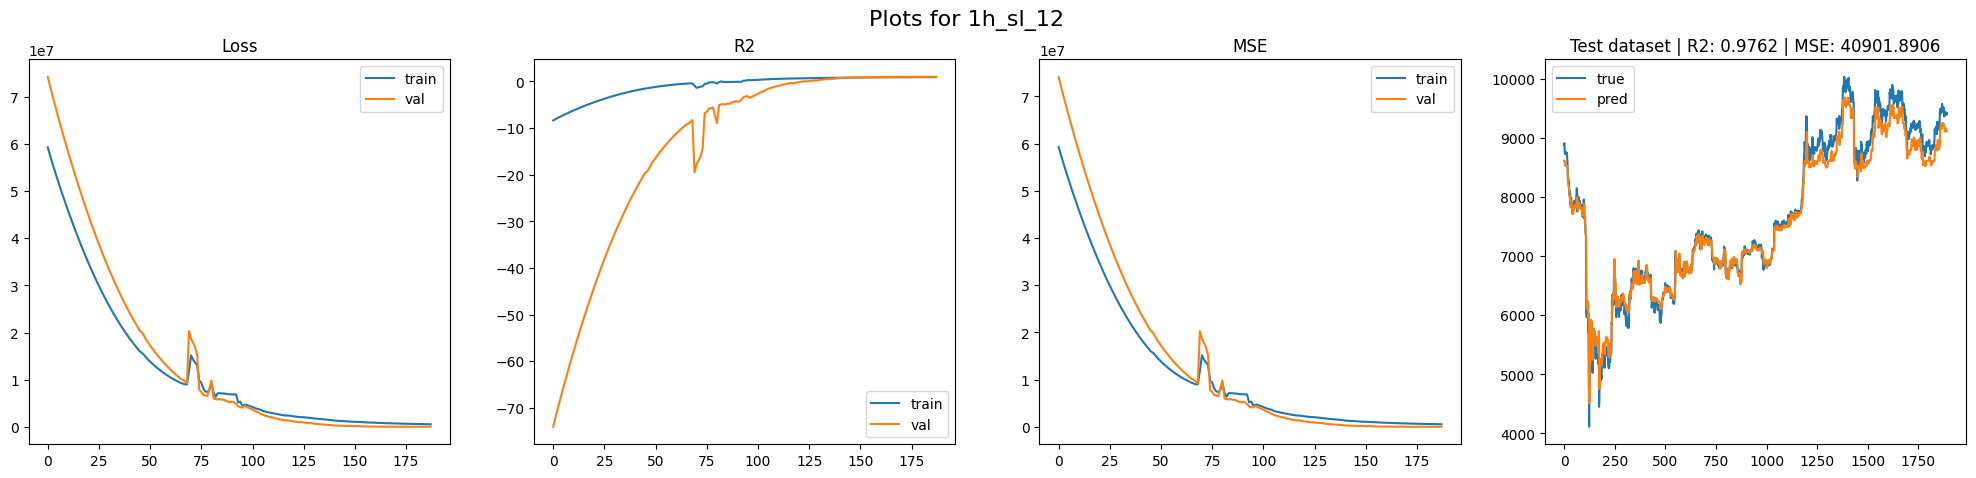

Epoch 180 | Train loss: 503572.5030 | Train R2: 0.9201 | Val loss: 7765.0965 | Val R2: 0.9920 | Val MSE: 7784.5054:  36%|███▌      | 181/500 [08:03<14:12,  2.67s/it]           

Early stopping at epoch 181


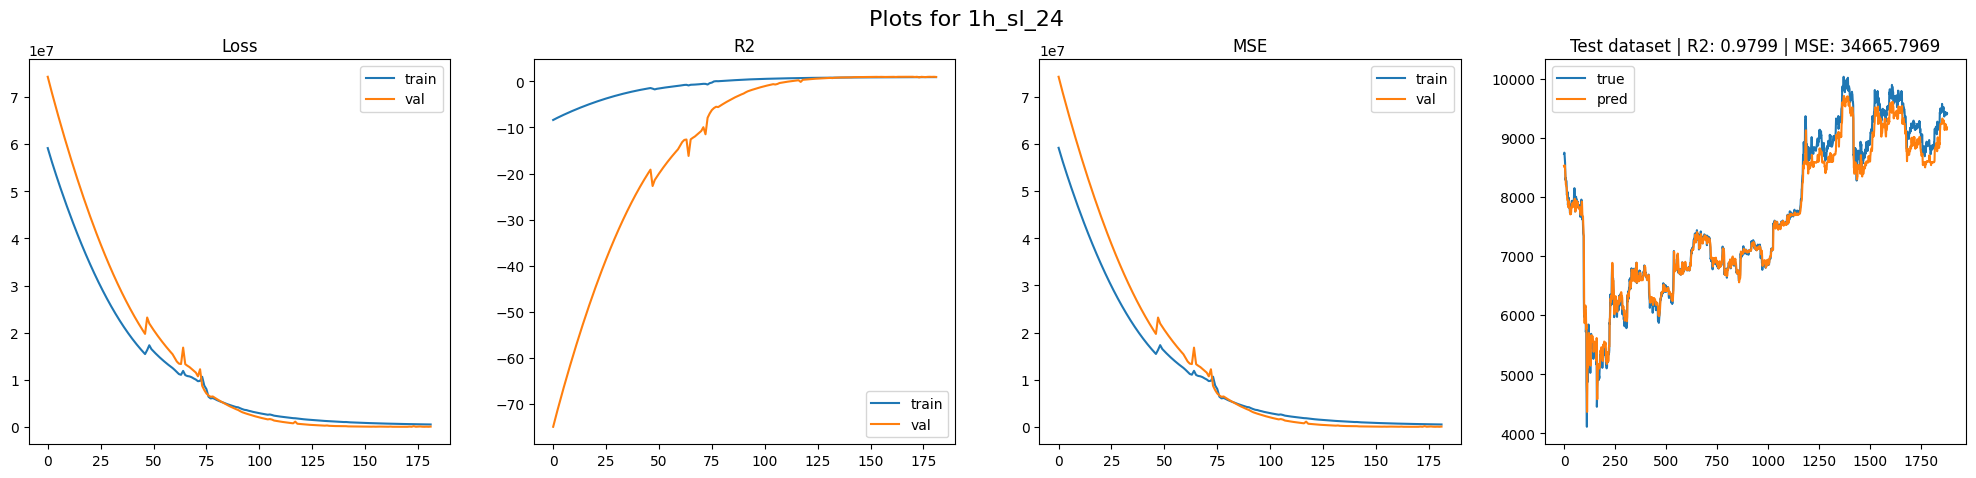

Epoch 189 | Train loss: 516221.0011 | Train R2: 0.9180 | Val loss: 28481.4136 | Val R2: 0.9710 | Val MSE: 28173.0137:  38%|███▊      | 190/500 [09:22<15:17,  2.96s/it]         

Early stopping at epoch 190


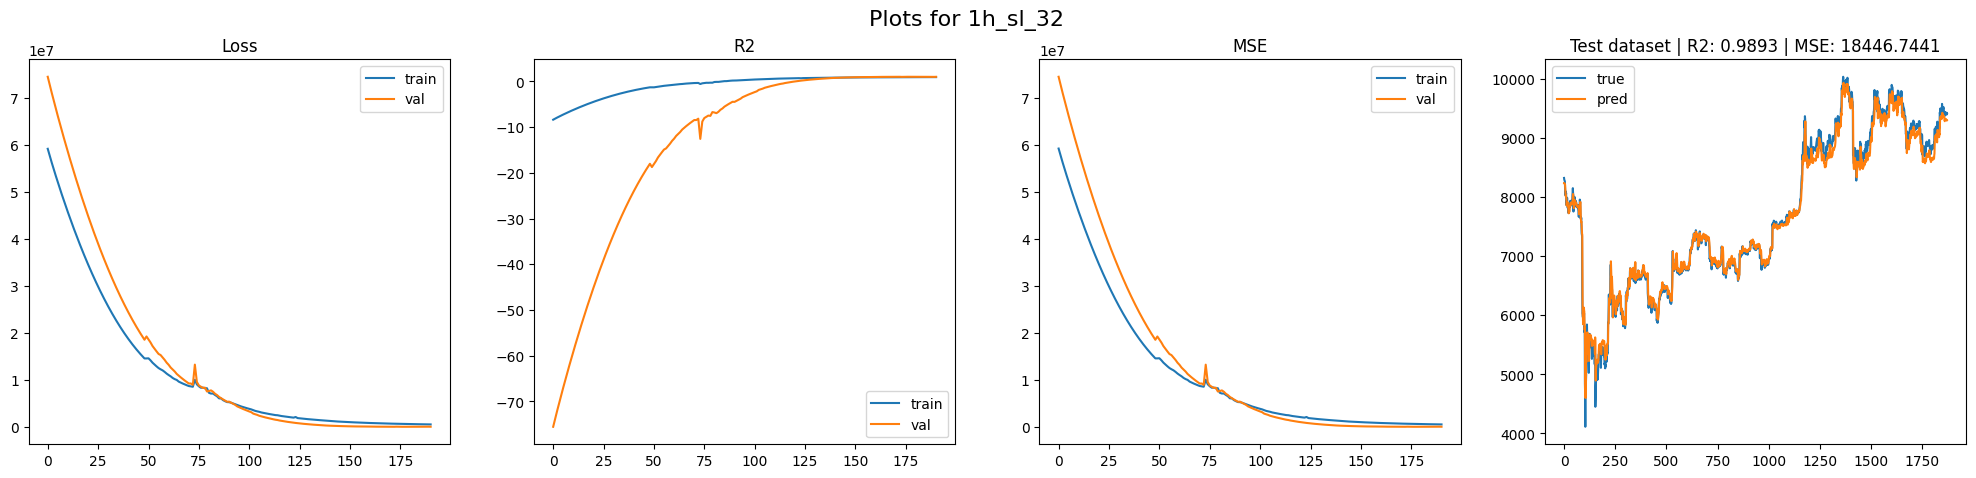

In [32]:
sequence_lengths_1h = [12, 24, 32]

for sequence_length in sequence_lengths_1h:
    hyperparams = {
        **hyperparams_1h,
        'sequence_length': sequence_length,
    }

    name = f'1h_sl_{sequence_length}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_1h, val_data_1h, hyperparams, name)
    validate(model, test_data_1h, sequence_length, hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)

Epoch 1561 | Train loss: 688049.0443 | Train R2: 0.8924 | Val loss: 71891.4688 | Val R2: 0.9411 | Val MSE: 68272.1719:  62%|██████▏   | 1562/2500 [03:57<02:22,  6.58it/s]


Early stopping at epoch 1562


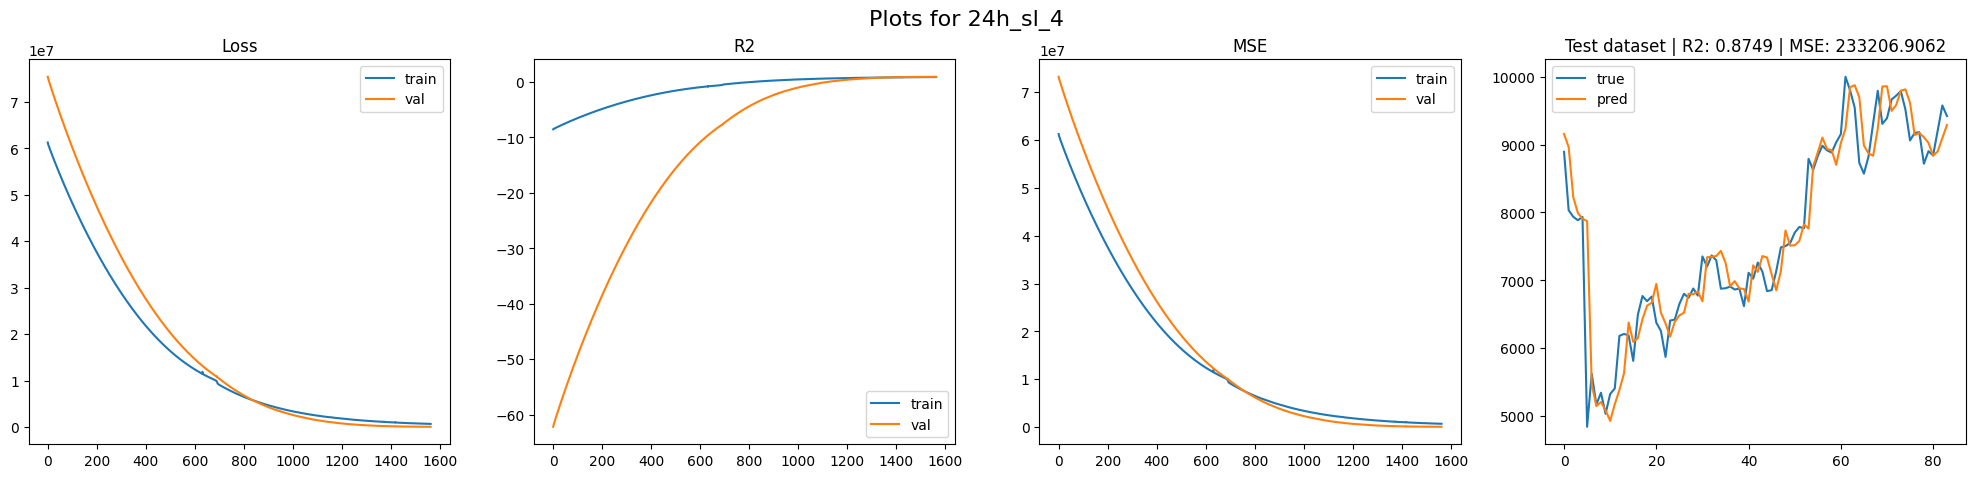

Epoch 735 | Train loss: 8460784.3321 | Train R2: -0.3977 | Val loss: 10483367.3333 | Val R2: -7.5800 | Val MSE: 9751423.0000:  29%|██▉       | 736/2500 [02:01<04:51,  6.05it/s]


Early stopping at epoch 736


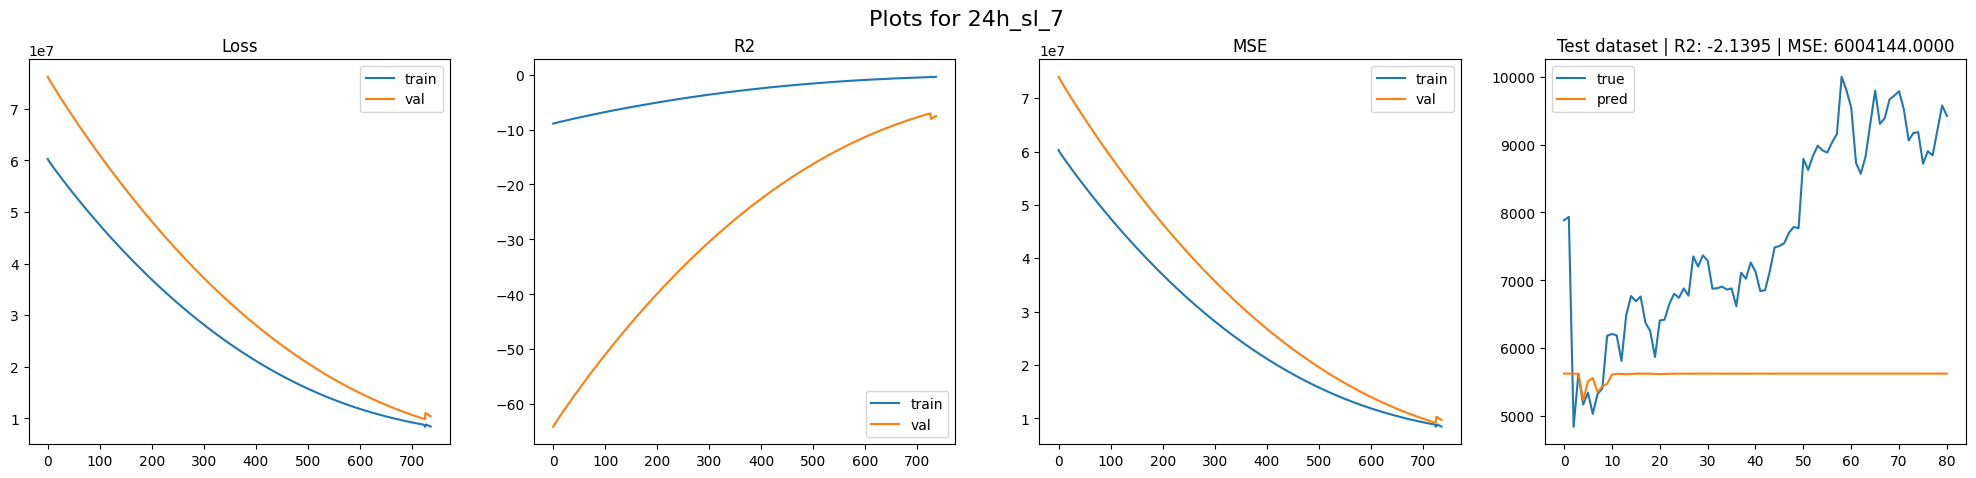

Epoch 1496 | Train loss: 345224.2076 | Train R2: 0.9379 | Val loss: 99658.1458 | Val R2: 0.9069 | Val MSE: 93696.2812:  60%|█████▉    | 1497/2500 [04:25<02:58,  5.63it/s]


Early stopping at epoch 1497


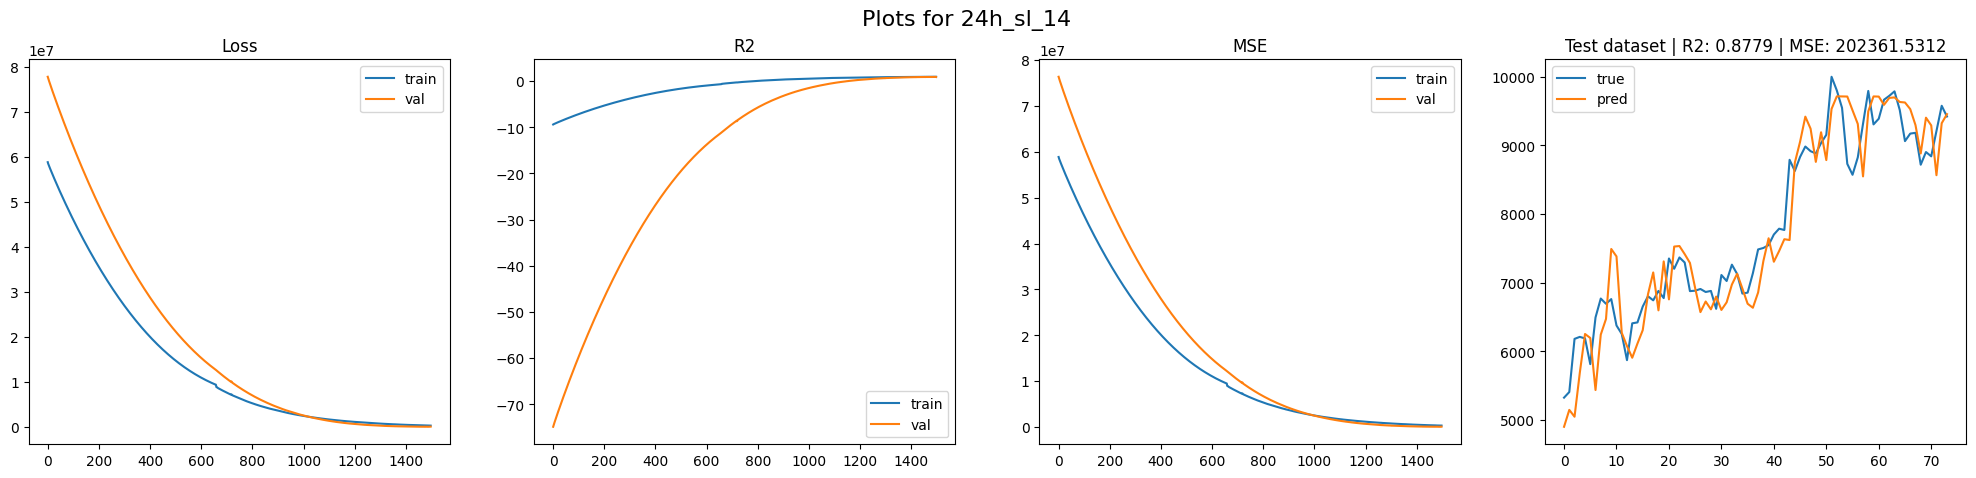

In [ ]:
sequence_lengths_24h = [4, 7, 14]

for sequence_length in sequence_lengths_24h:
    hyperparams = {
        **hyperparams_24h,
        'sequence_length': sequence_length,
    }

    name = f'24h_sl_{sequence_length}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_24h, val_data_24h, hyperparams, name)
    validate(model, test_data_24h, sequence_length, hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)

# Hidden size

Epoch 353 | Train loss: 524547.2622 | Train R2: 0.9168 | Val loss: 8332.0764 | Val R2: 0.9914 | Val MSE: 8366.3594:  71%|███████   | 354/500 [09:41<03:59,  1.64s/it]

Early stopping at epoch 354


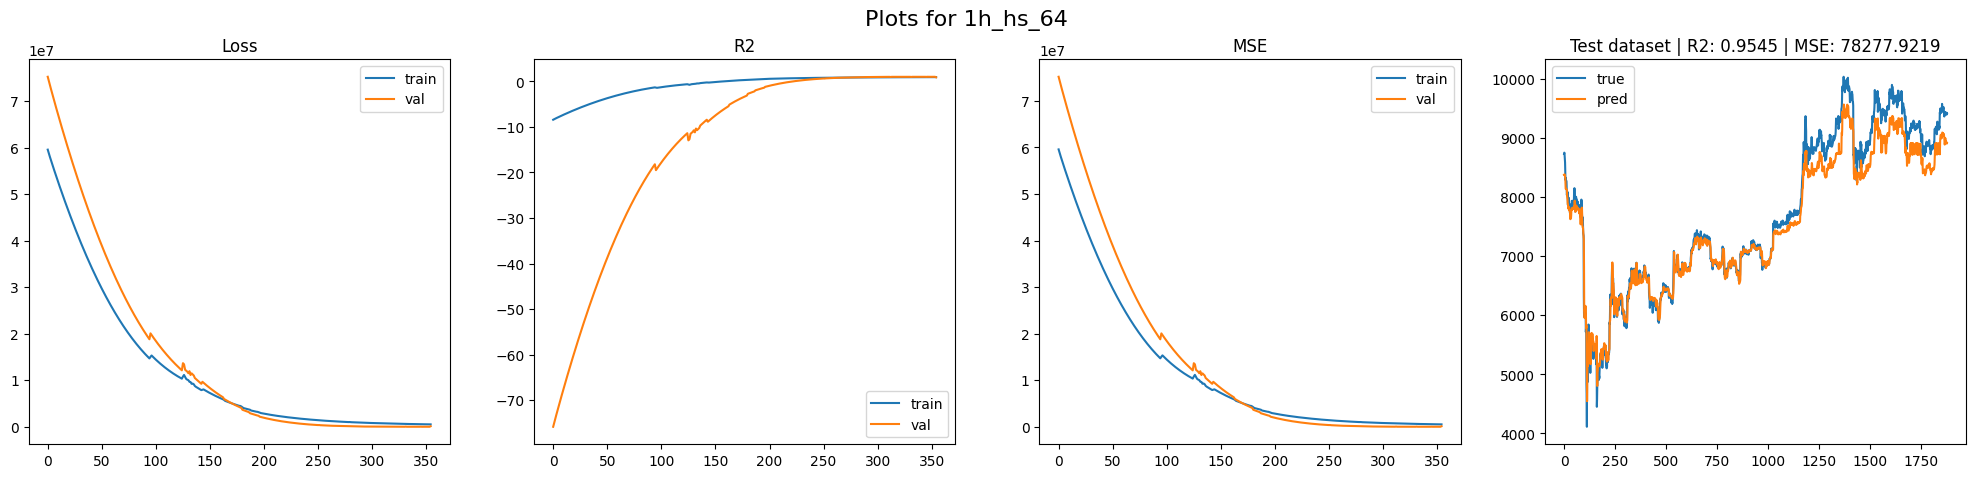

Epoch 183 | Train loss: 500590.3873 | Train R2: 0.9206 | Val loss: 12456.6461 | Val R2: 0.9873 | Val MSE: 12430.6250:  37%|███▋      | 184/500 [05:26<09:20,  1.77s/it]

Early stopping at epoch 184


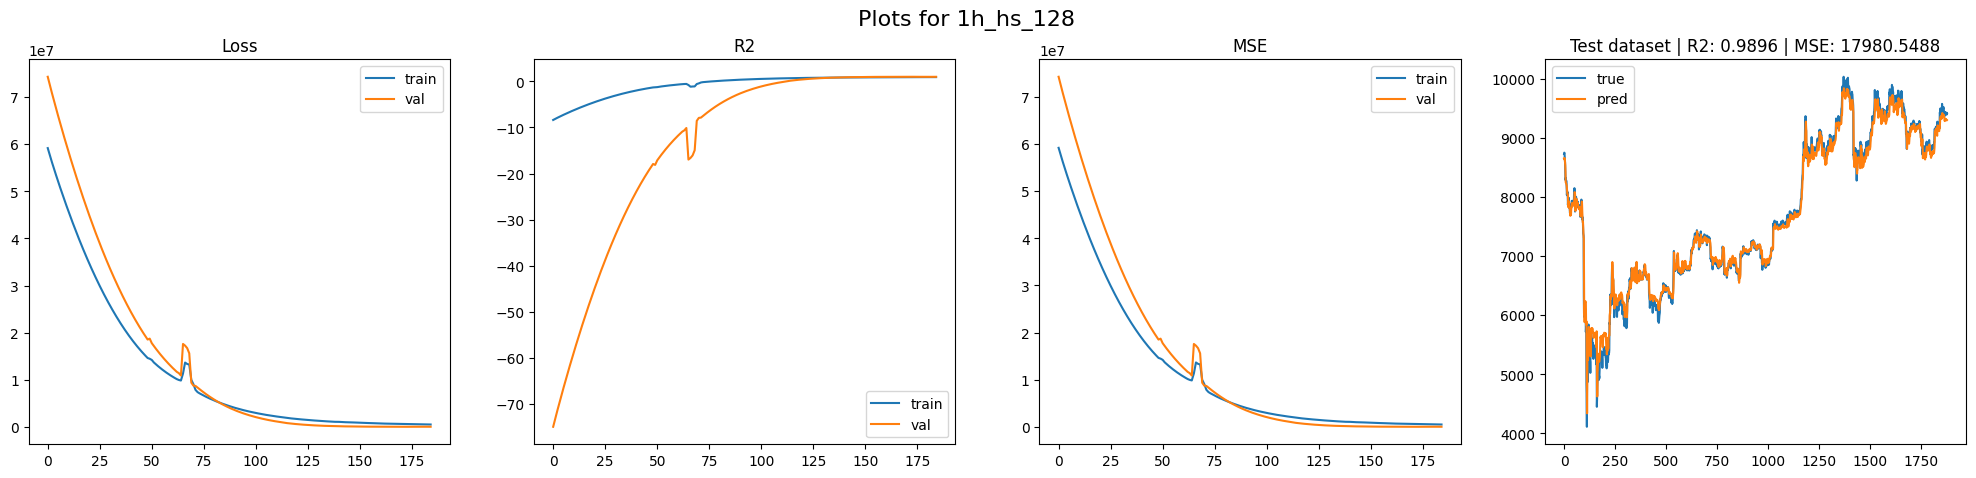

Epoch 115 | Train loss: 476727.2596 | Train R2: 0.9244 | Val loss: 9404.9352 | Val R2: 0.9904 | Val MSE: 9355.4658:  23%|██▎       | 116/500 [06:15<20:43,  3.24s/it]

Early stopping at epoch 116


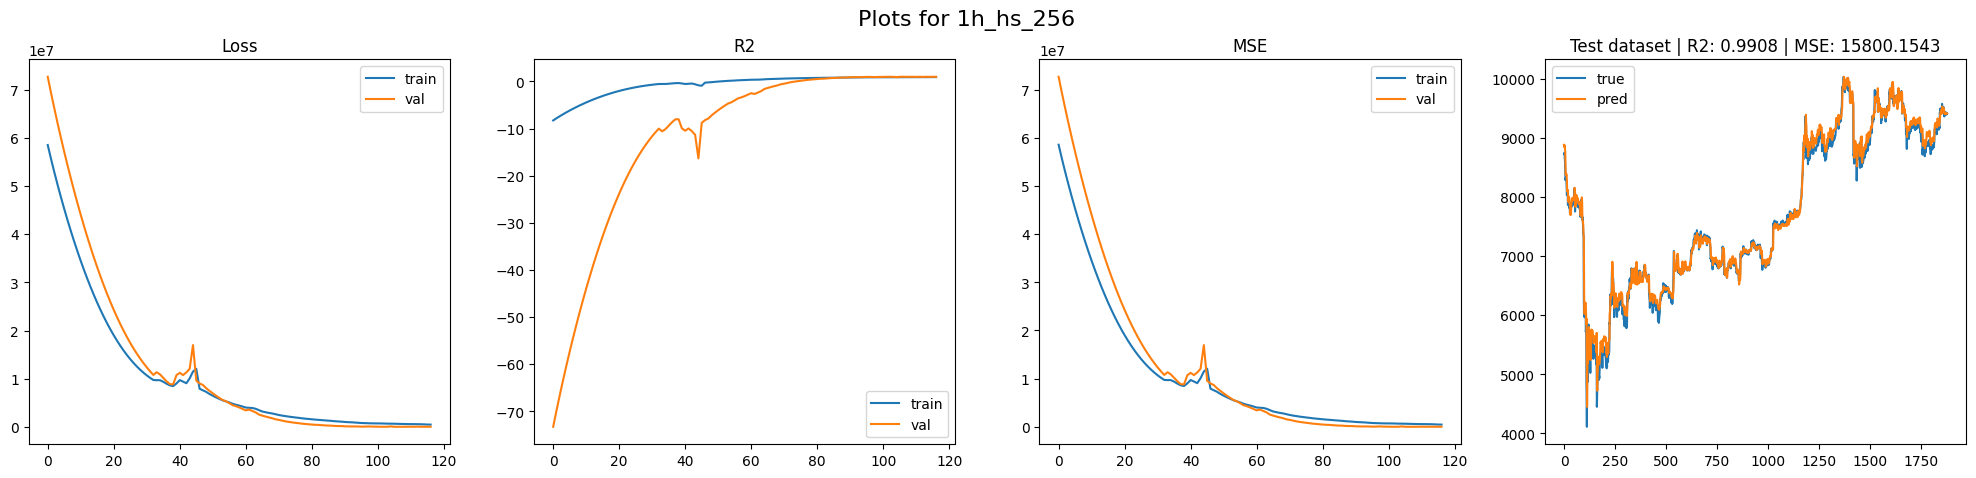

In [ ]:
hidden_sizes_1h = [64, 128, 256]

for hidden_size in hidden_sizes_1h:
    hyperparams = {
        **hyperparams_1h,
        'hidden_dim': hidden_size,
    }

    name = f'1h_hs_{hidden_size}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_1h, val_data_1h, hyperparams, name)
    validate(model, test_data_1h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)

Epoch 2499 | Train loss: 9522817.6103 | Train R2: -0.5724 | Val loss: 12034277.8333 | Val R2: -8.8892 | Val MSE: 11239411.0000: 100%|██████████| 2500/2500 [04:04<00:00, 10.23it/s]


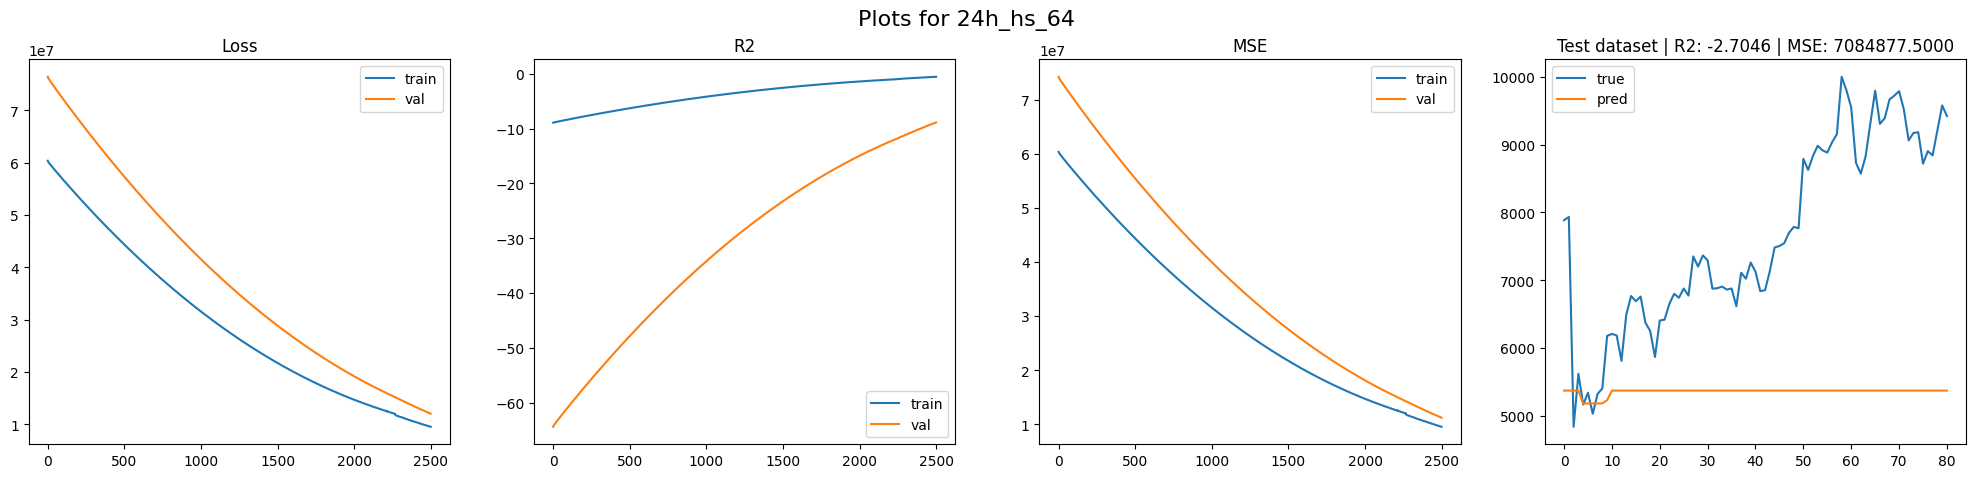

Epoch 2499 | Train loss: 960578.2027 | Train R2: 0.8404 | Val loss: 311715.0729 | Val R2: 0.7437 | Val MSE: 291252.3438: 100%|██████████| 2500/2500 [04:44<00:00,  8.79it/s]


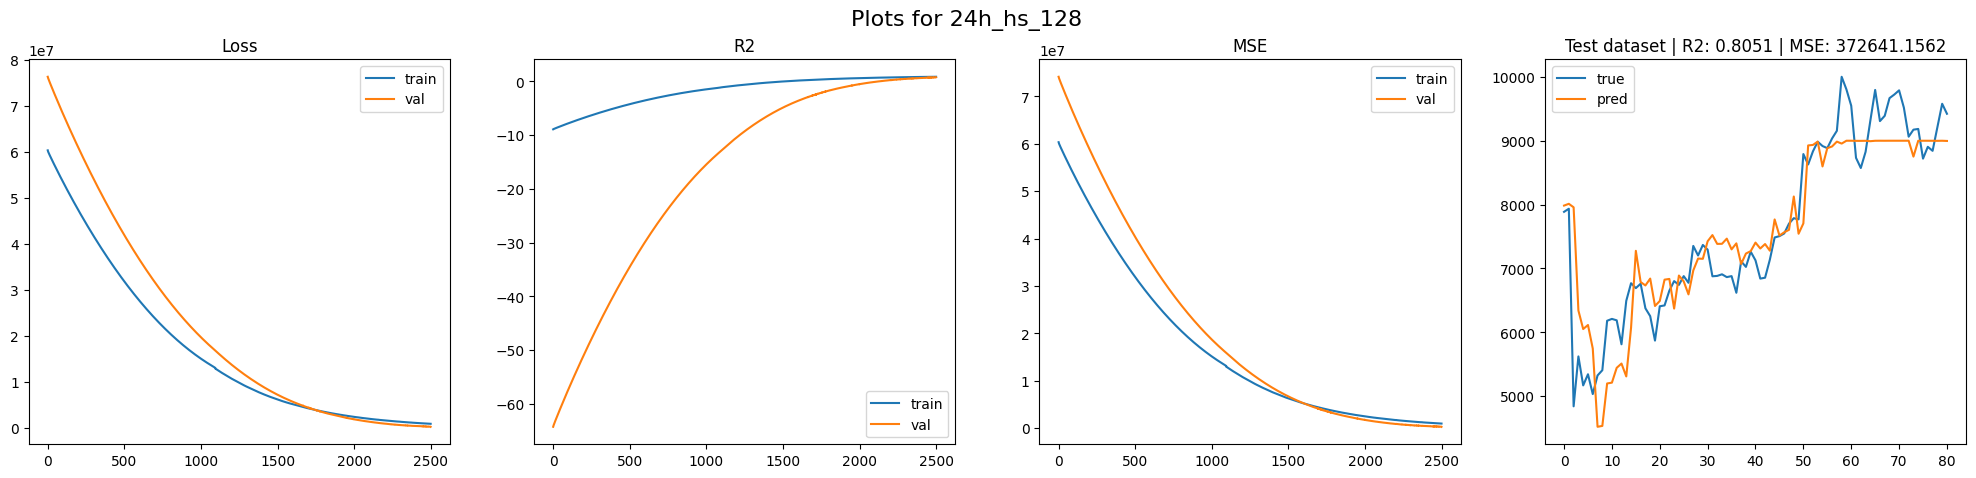

Epoch 1520 | Train loss: 552348.2358 | Train R2: 0.9083 | Val loss: 76096.7682 | Val R2: 0.9318 | Val MSE: 77479.5156:  61%|██████    | 1521/2500 [04:28<02:52,  5.68it/s]


Early stopping at epoch 1521


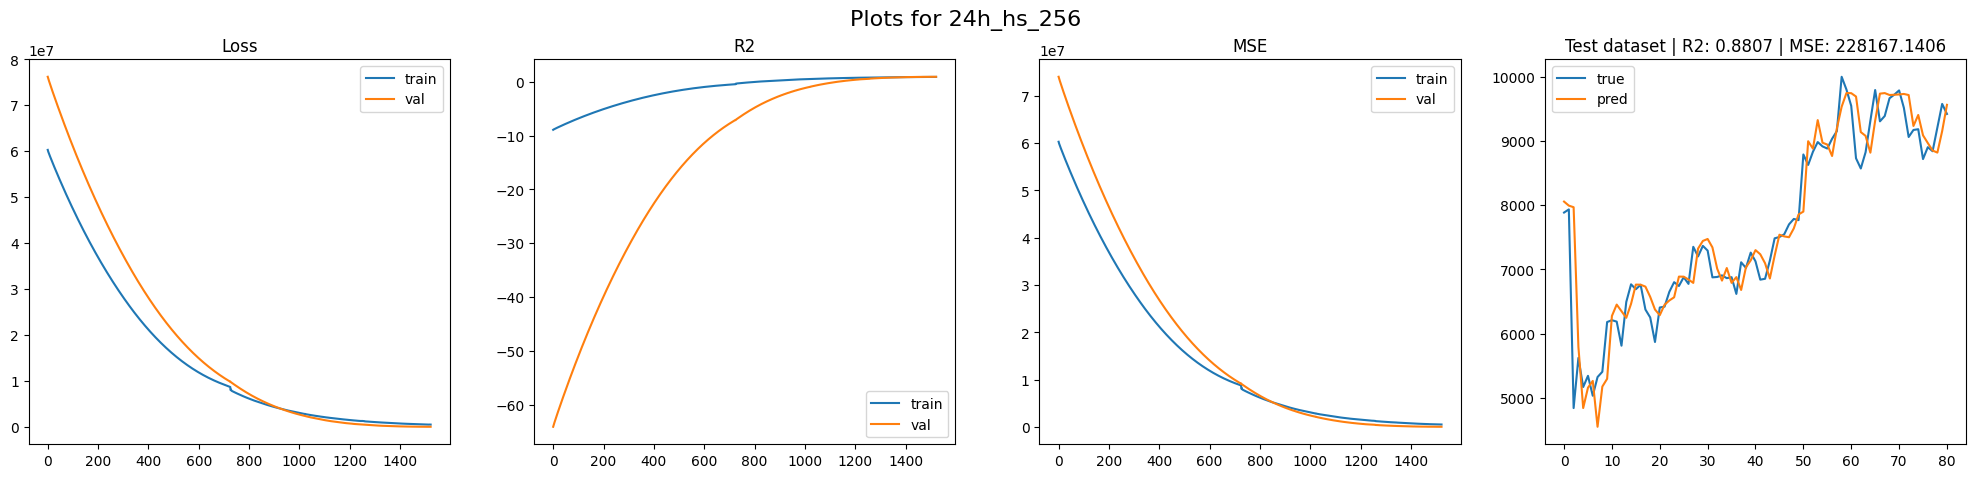

In [ ]:
hidden_sizes_24h = [64, 128, 256]

for hidden_size in hidden_sizes_24h:
    hyperparams = {
        **hyperparams_24h,
        'hidden_dim': hidden_size,
    }

    name = f'24h_hs_{hidden_size}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_24h, val_data_24h, hyperparams, name)
    validate(model, test_data_24h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)

# Dropout after LSTM

Epoch 192 | Train loss: 525794.1840 | Train R2: 0.9166 | Val loss: 8301.0240 | Val R2: 0.9916 | Val MSE: 8251.4570:  39%|███▊      | 193/500 [06:17<10:00,  1.96s/it]

Early stopping at epoch 193


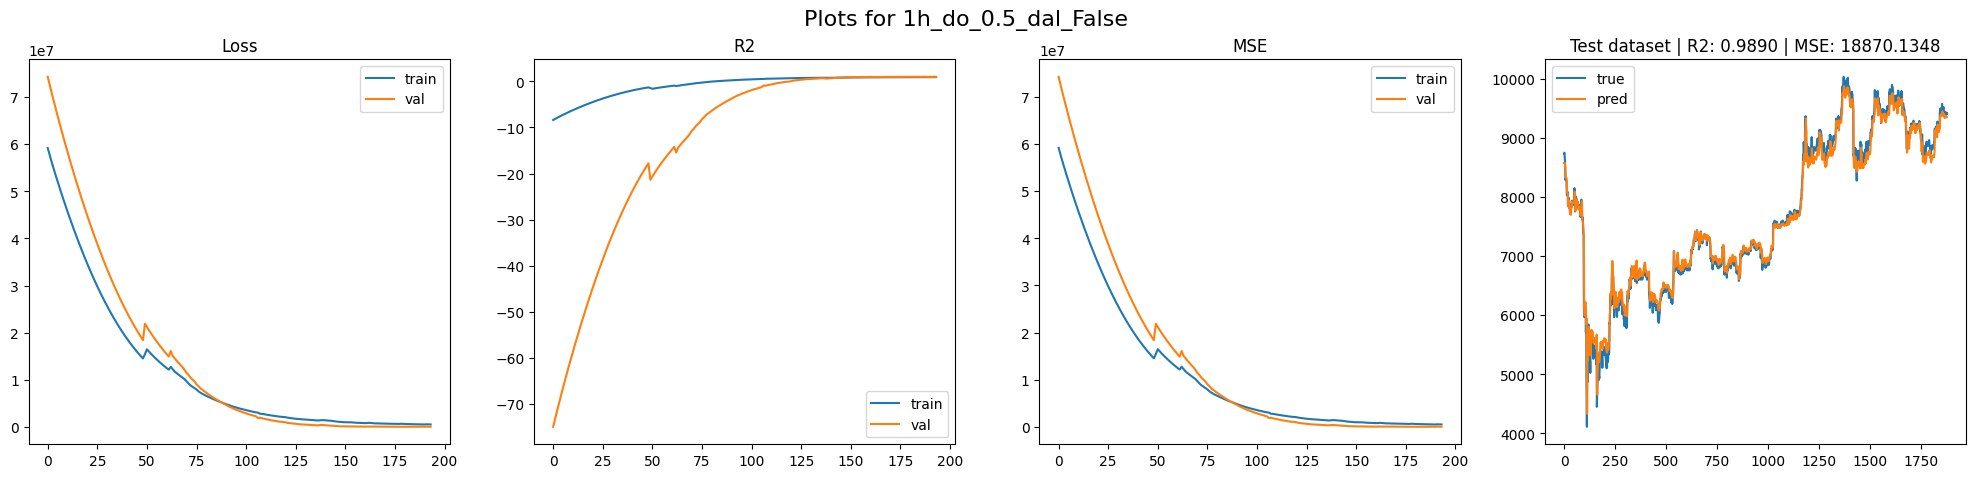

Epoch 188 | Train loss: 768075.5281 | Train R2: 0.8782 | Val loss: 39353.3570 | Val R2: 0.9599 | Val MSE: 39275.6328:  38%|███▊      | 189/500 [06:13<10:15,  1.98s/it]

Early stopping at epoch 189


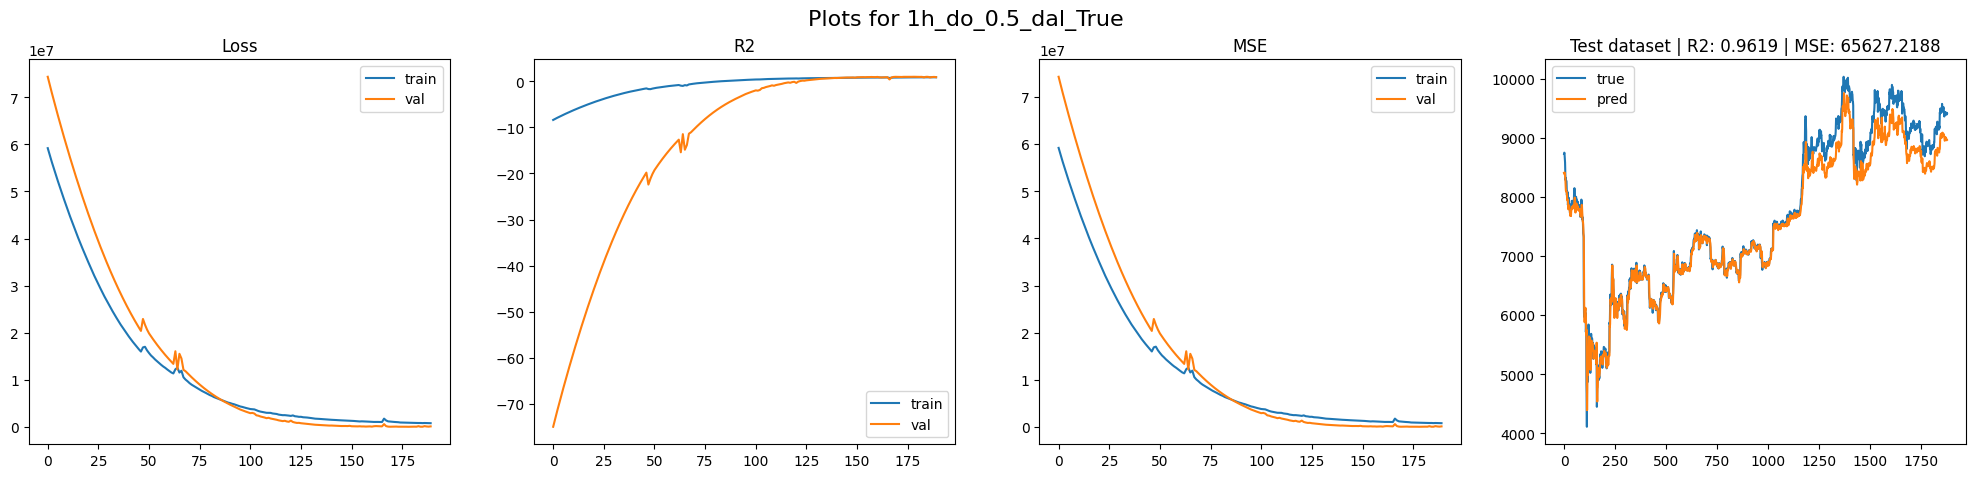

Epoch 174 | Train loss: 722419.3344 | Train R2: 0.8854 | Val loss: 20759.2056 | Val R2: 0.9787 | Val MSE: 20847.1719:  35%|███▌      | 175/500 [05:34<10:21,  1.91s/it]

Early stopping at epoch 175


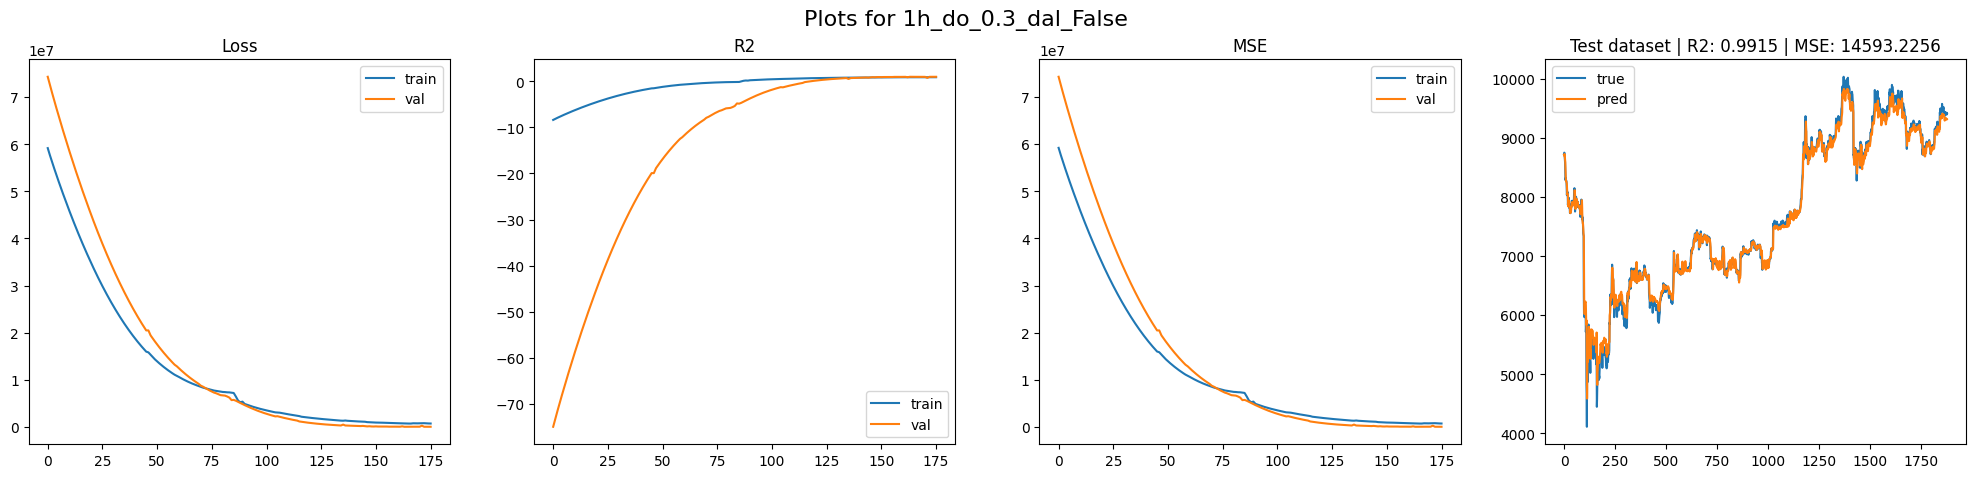

Epoch 191 | Train loss: 629988.0098 | Train R2: 0.9001 | Val loss: 14418.0749 | Val R2: 0.9852 | Val MSE: 14454.0986:  38%|███▊      | 192/500 [06:45<10:50,  2.11s/it]

Early stopping at epoch 192


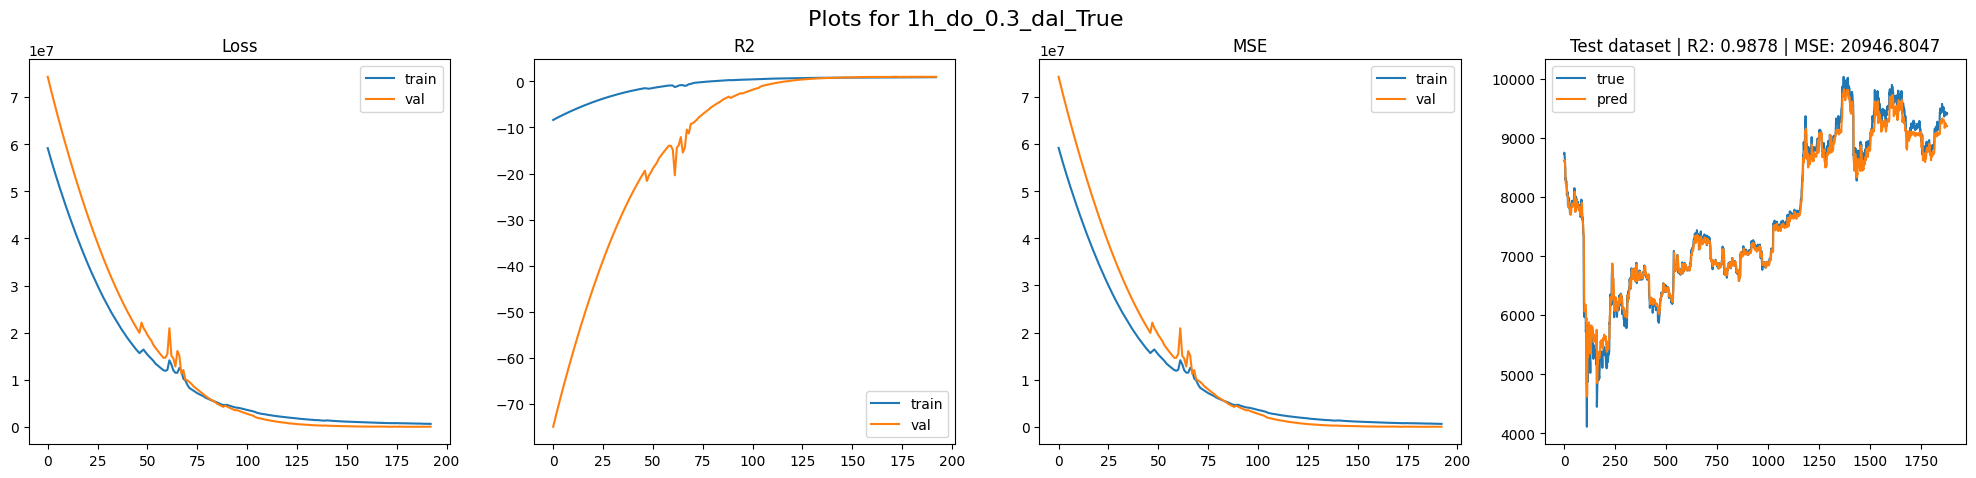

In [ ]:
dropout_1h = [(0.5, False), (0.5, True), (0.3, False), (0.3, True)]

for dropout in dropout_1h:
    hyperparams = {
        **hyperparams_1h,
        'dropout': dropout[0],
        'dropout_after_lstm': dropout[1]
    }

    name = f'1h_do_{dropout[0]}_dal_{dropout[1]}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_1h, val_data_1h, hyperparams, name)
    validate(model, test_data_1h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)


Epoch 1551 | Train loss: 470545.2349 | Train R2: 0.9219 | Val loss: 67612.3568 | Val R2: 0.9412 | Val MSE: 66786.6875:  62%|██████▏   | 1552/2500 [04:37<02:49,  5.59it/s]


Early stopping at epoch 1552


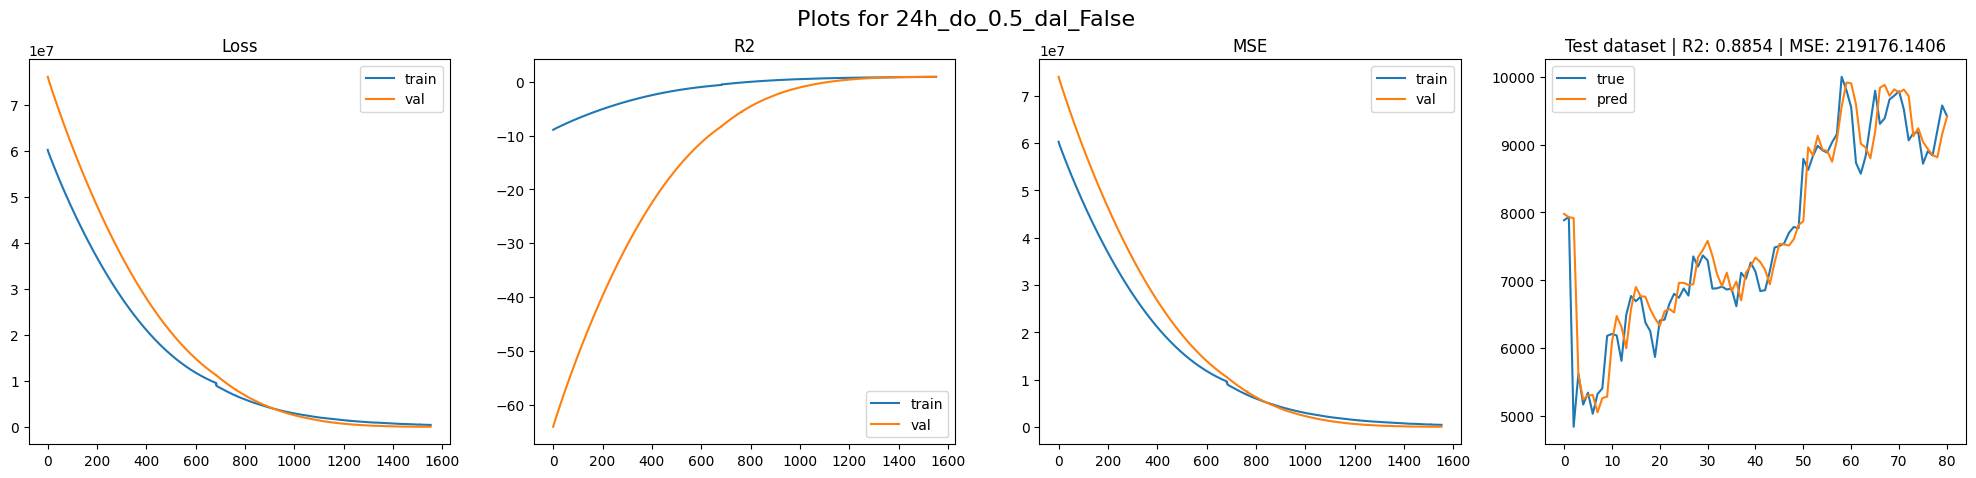

Epoch 1547 | Train loss: 733518.6708 | Train R2: 0.8785 | Val loss: 107113.0573 | Val R2: 0.9029 | Val MSE: 110344.2969:  62%|██████▏   | 1548/2500 [04:47<02:57,  5.38it/s]


Early stopping at epoch 1548


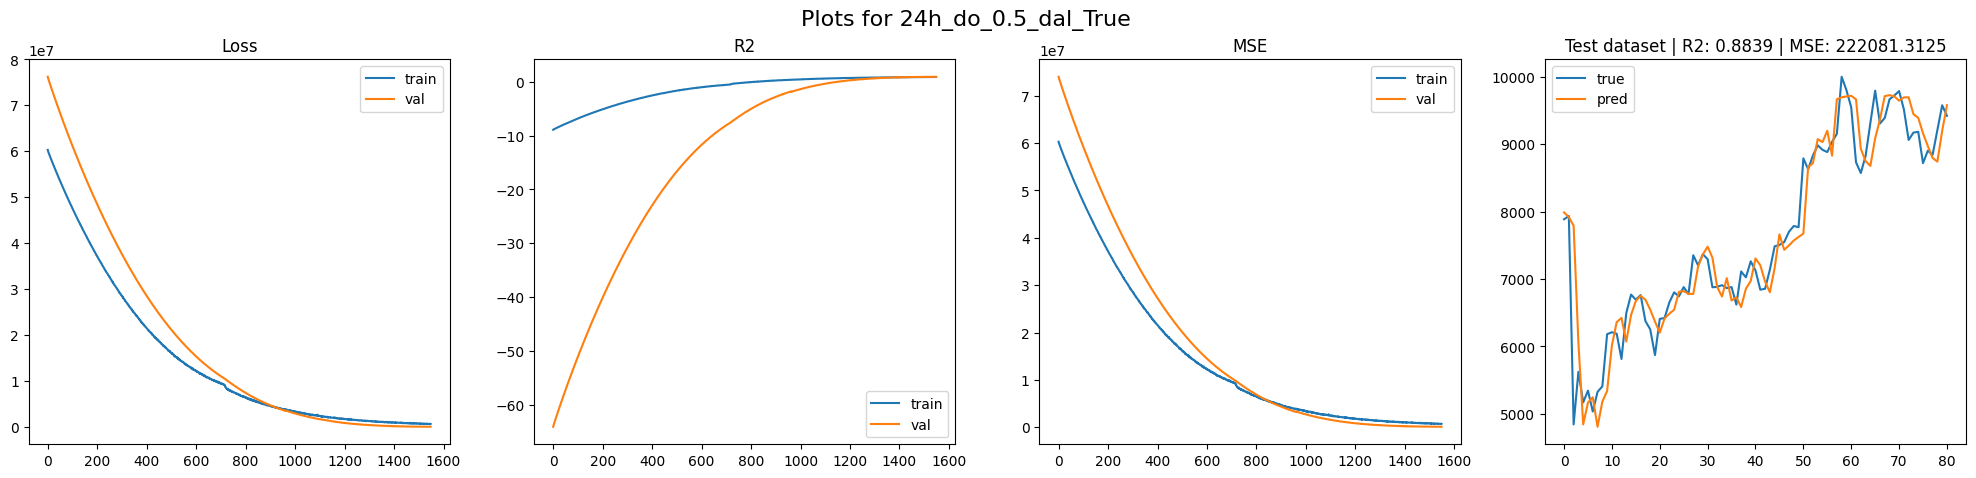

Epoch 1365 | Train loss: 970757.2956 | Train R2: 0.8387 | Val loss: 288416.4219 | Val R2: 0.7614 | Val MSE: 271182.2812:  55%|█████▍    | 1366/2500 [04:28<03:43,  5.08it/s]


Early stopping at epoch 1366


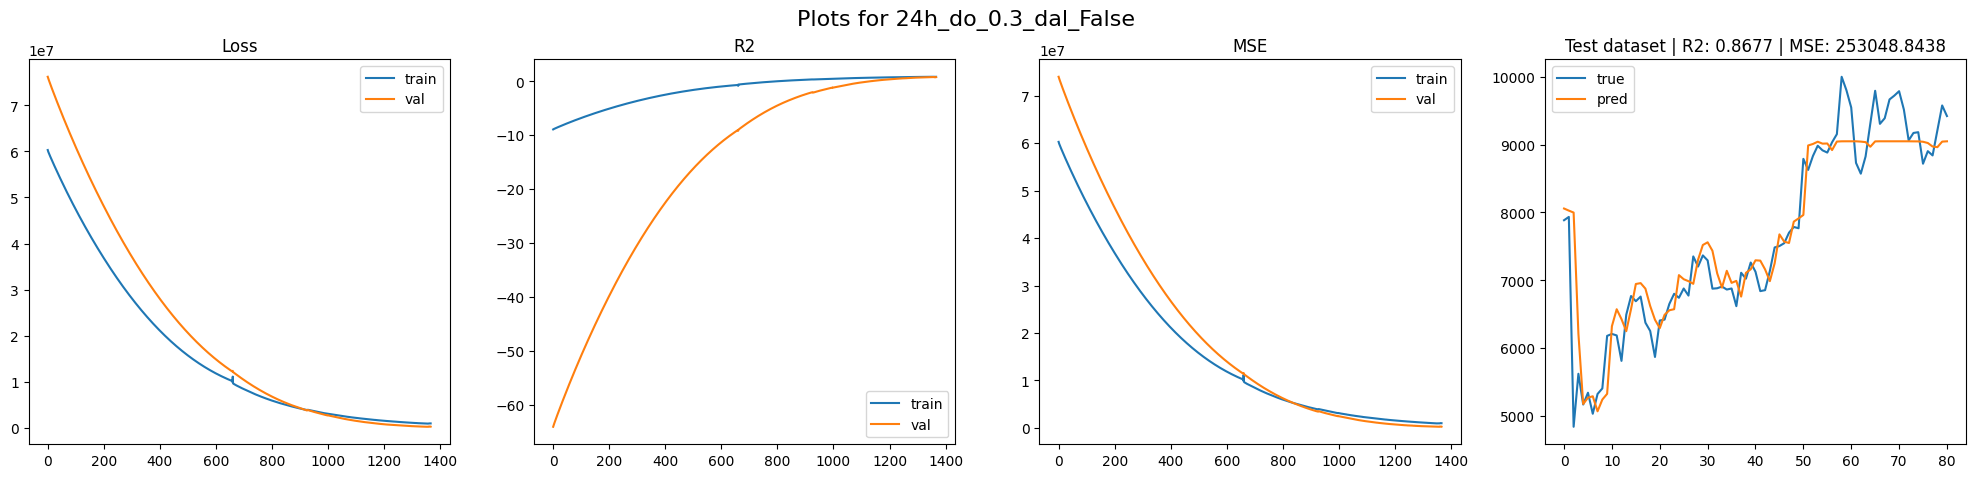

Epoch 894 | Train loss: 4738633.4327 | Train R2: 0.2151 | Val loss: 5059491.8750 | Val R2: -3.0521 | Val MSE: 4605335.5000:  36%|███▌      | 895/2500 [03:00<05:24,  4.95it/s]


Early stopping at epoch 895


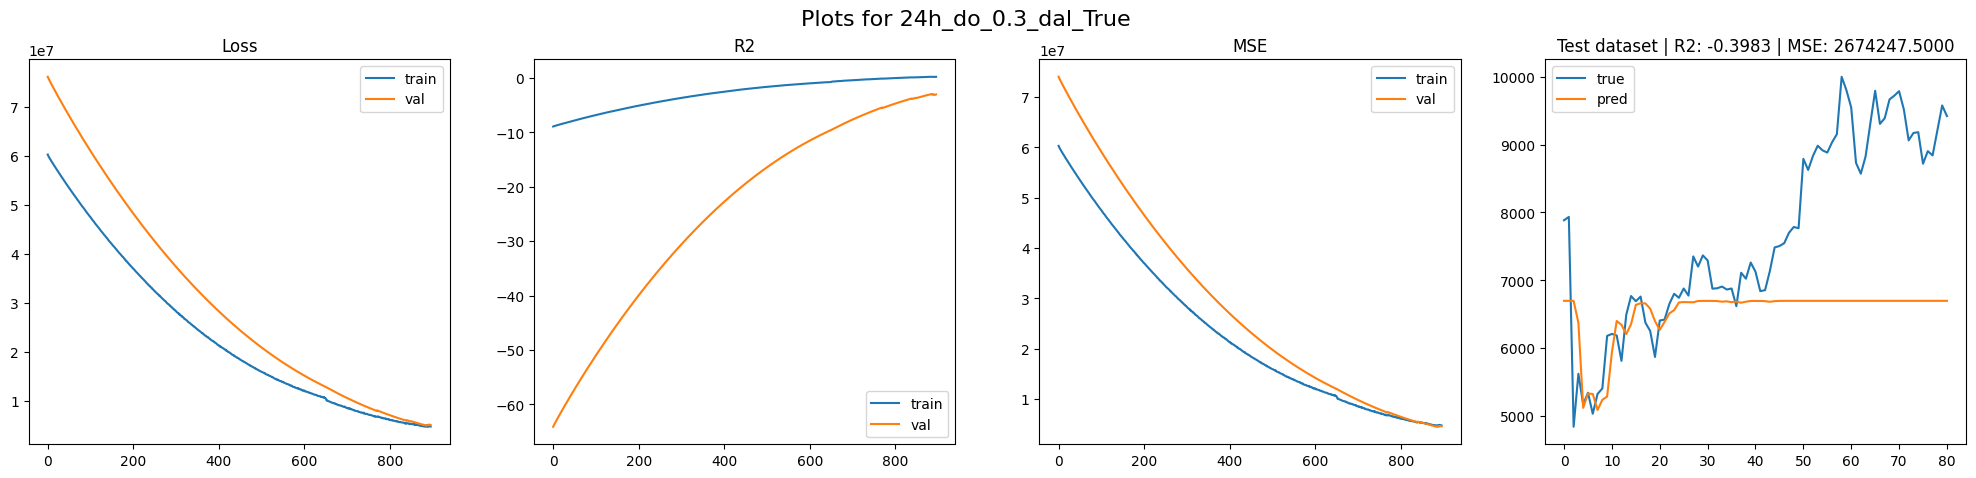

In [ ]:
dropout_24h = [(0.5, False), (0.5, True), (0.3, False), (0.3, True)]

for dropout in dropout_24h:
    hyperparams = {
        **hyperparams_24h,
        'dropout': dropout[0],
        'dropout_after_lstm': dropout[1]
    }

    name = f'24h_do_{dropout[0]}_dal_{dropout[1]}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_24h, val_data_24h, hyperparams, name)
    validate(model, test_data_24h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)

# Preprocessing

Epoch 192 | Train loss: 436649.8080 | Train R2: 0.9307 | Val loss: 8003.9978 | Val R2: 0.9918 | Val MSE: 8035.0059:  39%|███▊      | 193/500 [06:04<09:39,  1.89s/it]

Early stopping at epoch 193


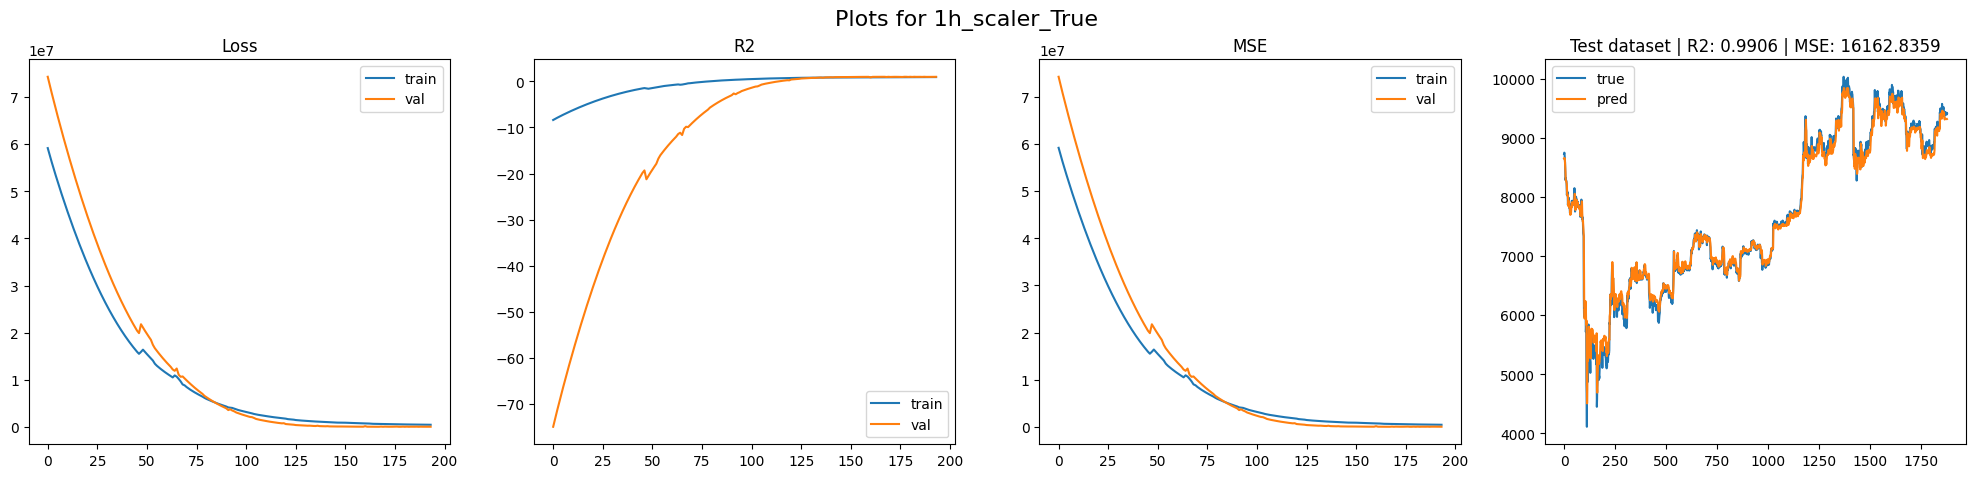

Epoch 124 | Train loss: 7874766.6636 | Train R2: -0.2493 | Val loss: 7642242.7945 | Val R2: -6.8042 | Val MSE: 7635302.5000:  25%|██▌       | 125/500 [04:05<12:15,  1.96s/it]

Early stopping at epoch 125


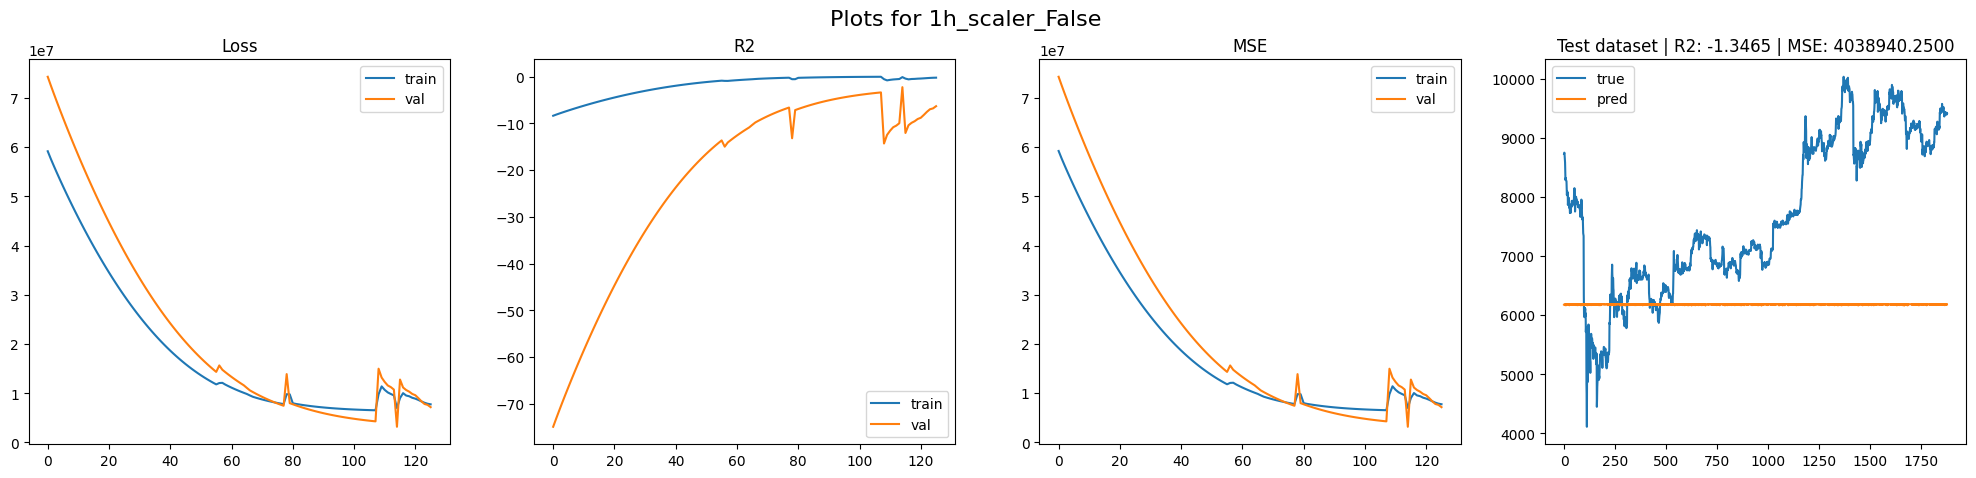

In [ ]:
use_scaler = [True, False]

for scaler in use_scaler:
    hyperparams = {
        **hyperparams_1h
    }

    name = f'1h_scaler_{scaler}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_1h, val_data_1h, hyperparams, name, scaler)
    validate(model, test_data_1h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)

Epoch 1467 | Train loss: 648949.6666 | Train R2: 0.8922 | Val loss: 114509.7578 | Val R2: 0.8992 | Val MSE: 114547.6641:  59%|█████▊    | 1468/2500 [04:30<03:10,  5.43it/s]


Early stopping at epoch 1468


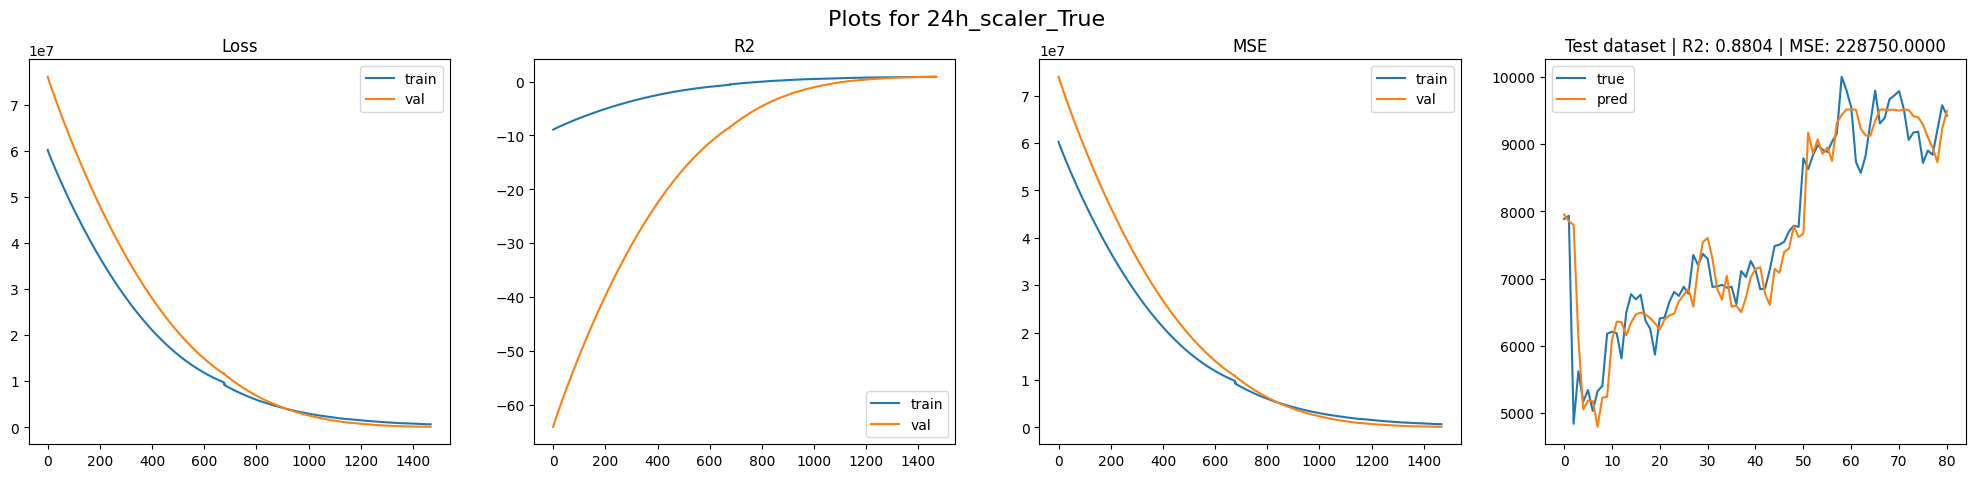

Epoch 2499 | Train loss: 6023908.1278 | Train R2: -0.0003 | Val loss: 2809287.6979 | Val R2: -1.2267 | Val MSE: 2530687.2500: 100%|██████████| 2500/2500 [08:13<00:00,  5.07it/s]


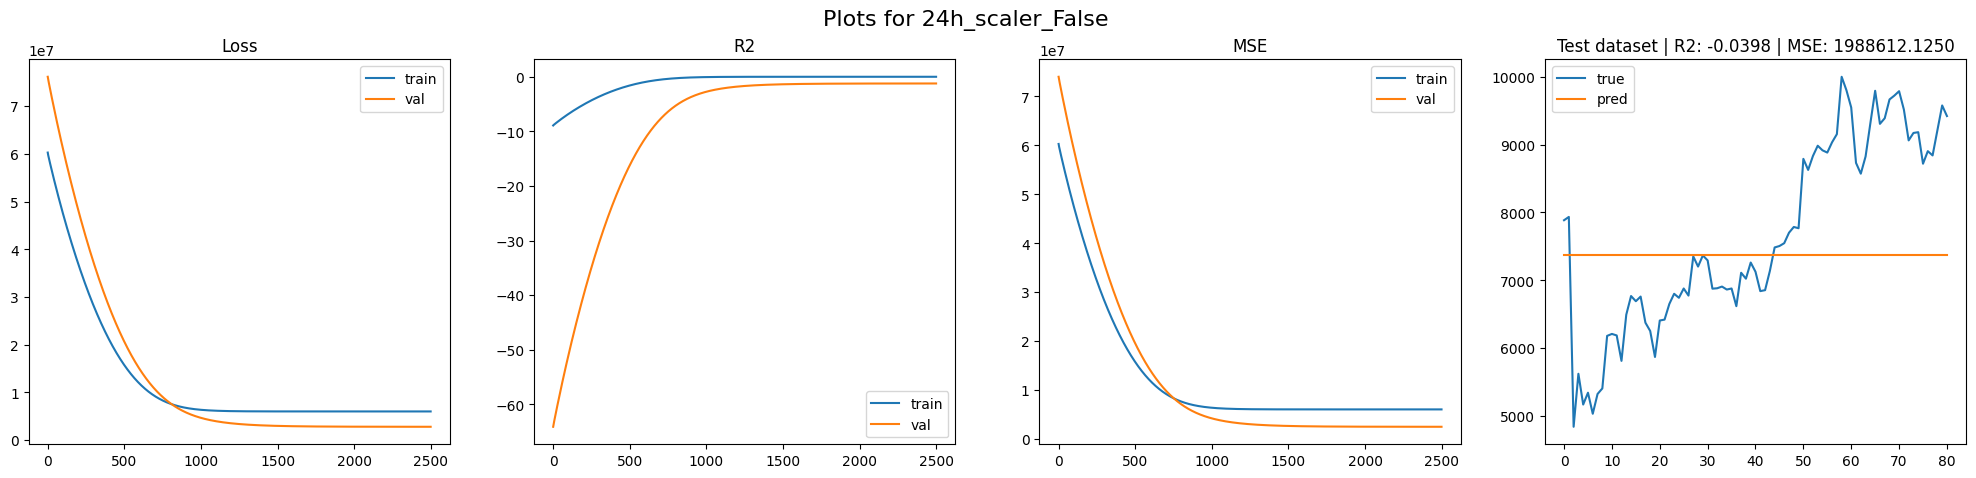

In [ ]:
use_scaler = [True, False]

for scaler in use_scaler:
    hyperparams = {
        **hyperparams_24h
    }

    name = f'24h_scaler_{scaler}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_24h, val_data_24h, hyperparams, name, scaler)
    validate(model, test_data_24h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores)

# Affective dimensions

Epoch 184 | Train loss: 524254.6892 | Train R2: 0.9168 | Val loss: 31387.4860 | Val R2: 0.9681 | Val MSE: 31211.3770:  37%|███▋      | 185/500 [06:01<10:16,  1.96s/it]

Early stopping at epoch 185


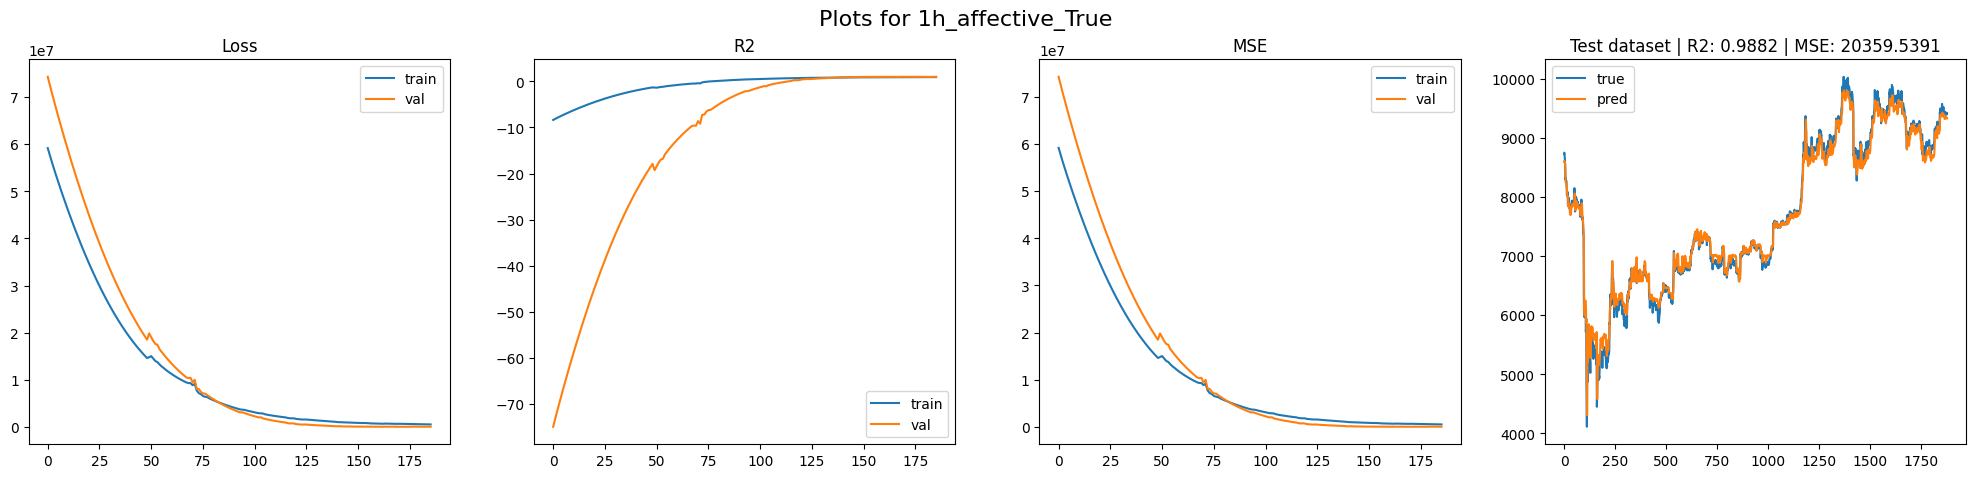

Epoch 197 | Train loss: 487101.5795 | Train R2: 0.9227 | Val loss: 17534.6544 | Val R2: 0.9821 | Val MSE: 17513.3281:  40%|███▉      | 198/500 [06:21<09:41,  1.93s/it]

Early stopping at epoch 198


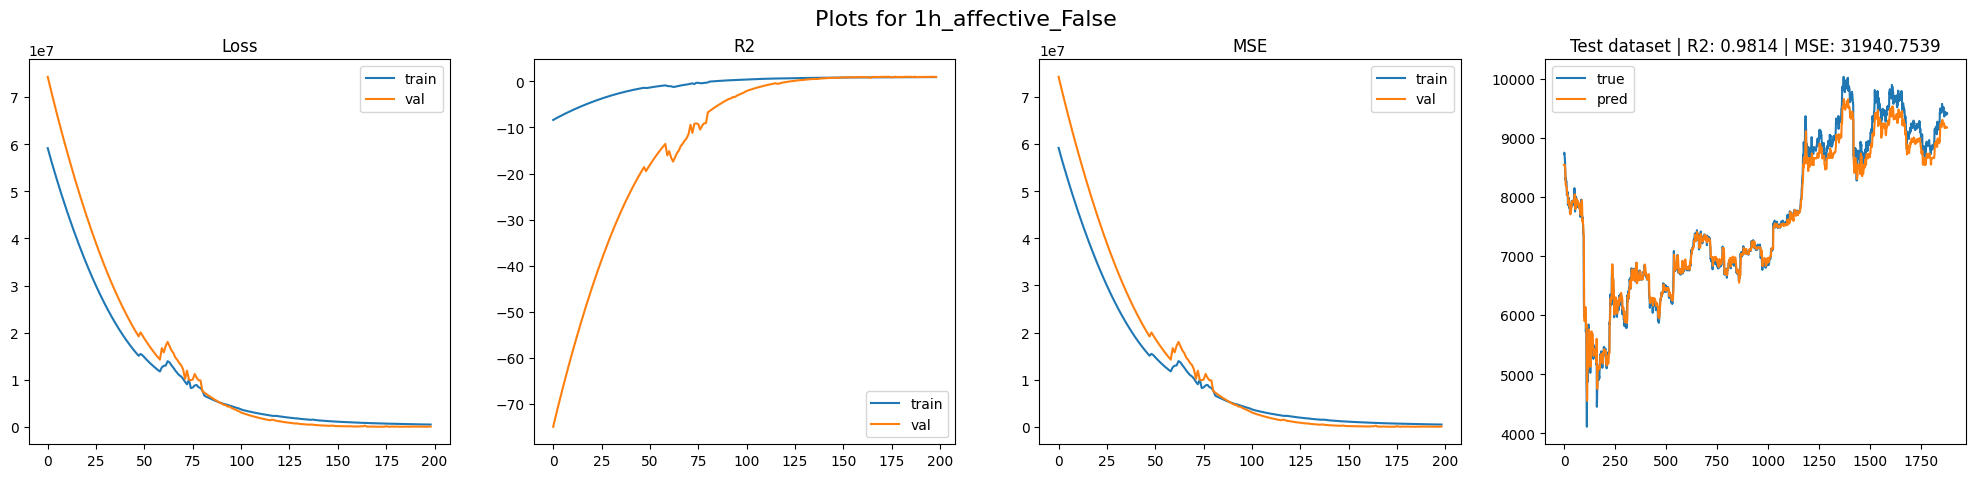

In [ ]:
use_affective_dimensions = [True, False]

for use_affective in use_affective_dimensions:
    hyperparams = {
        **hyperparams_1h,
        'input_dim': 8 if use_affective else 6
    }

    name = f'1h_affective_{use_affective}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_1h, val_data_1h, hyperparams, name, aff_dim=use_affective)
    validate(model, test_data_1h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores, aff_dim=use_affective)

Epoch 1361 | Train loss: 945014.2904 | Train R2: 0.8430 | Val loss: 262480.1328 | Val R2: 0.7844 | Val MSE: 244986.7969:  54%|█████▍    | 1362/2500 [04:09<03:28,  5.45it/s]


Early stopping at epoch 1362


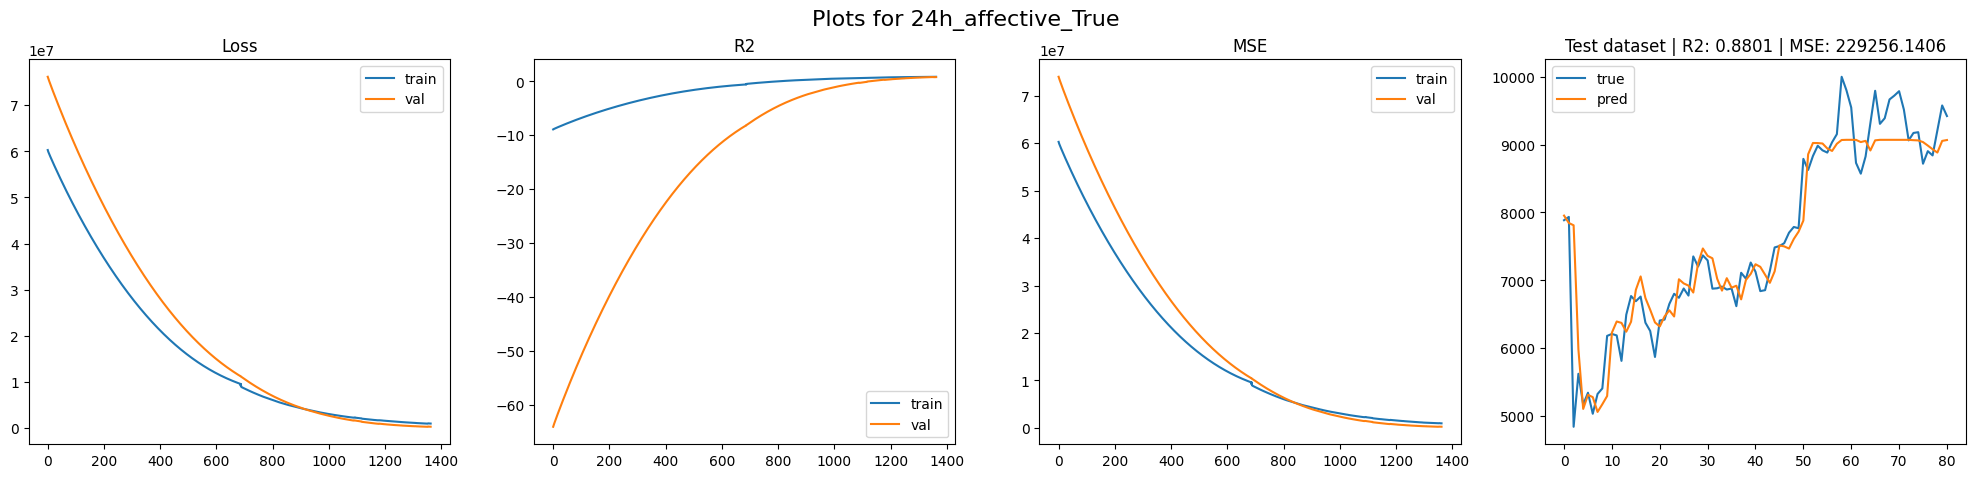

Epoch 1493 | Train loss: 545520.4845 | Train R2: 0.9094 | Val loss: 93695.7552 | Val R2: 0.9174 | Val MSE: 93839.1406:  60%|█████▉    | 1494/2500 [04:28<03:00,  5.57it/s]


Early stopping at epoch 1494


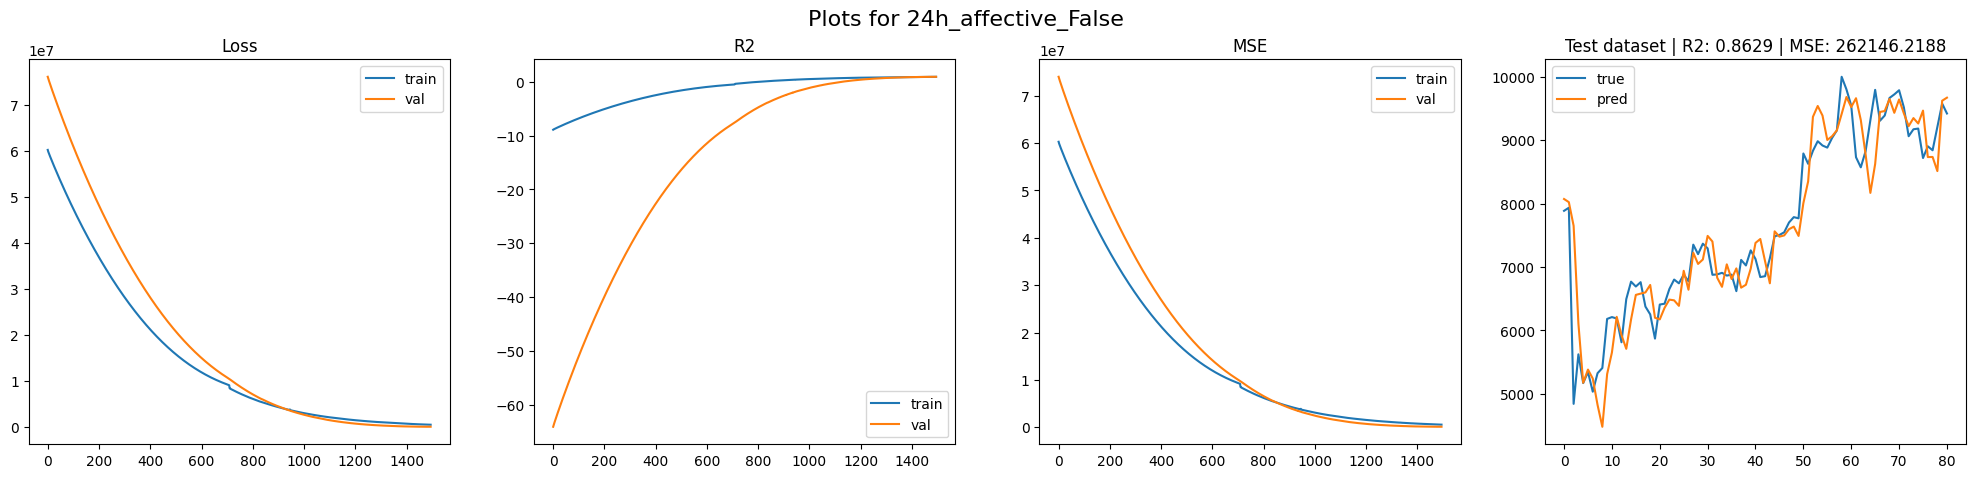

In [50]:
use_affective_dimensions = [True, False]

for use_affective in use_affective_dimensions:
    hyperparams = {
        **hyperparams_24h,
        'input_dim': 8 if use_affective else 6
    }

    name = f'24h_affective_{use_affective}'
    model, scaler, losses, r2_scores, mse_scores = test_all(train_data_24h, val_data_24h, hyperparams, name, aff_dim=use_affective)
    validate(model, test_data_24h, hyperparams['sequence_length'], hyperparams['batch_size'], scaler, name, losses, r2_scores, mse_scores, aff_dim=use_affective)